In [1]:
import warnings
import sys
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')

In [2]:
import jax.numpy as jnp
from jax import random, vmap, clear_caches
import numpy as np

import optax
import matplotlib.pyplot as plt
from functools import partial

from data import dataset_LLT
from conj_grad import ConjGrad, apply_LLT
from loss import Notay_loss
from model import MessagePassingWithDiag, MessagePassingNoDiag, FullyConnectedNet
from prec_models import PrecNetLearnAll, PrecNetCopyDiag, PrecNetCopyDiagSqrt, PrecNetRigidLDLT

from utils import params_count, asses_cond, iter_per_residual
from data import direc_graph_from_linear_system_sparse
from train import train

# Make dataset

In [3]:
grid = 32
N_samples_train = 16
N_samples_test = 10

In [4]:
A_train, b_train, u_exact_train, bi_edges_train = dataset_LLT(grid, N_samples_train, seed=42)
A_test, b_test, u_exact_test, bi_edges_test = dataset_LLT(grid, N_samples_test, seed=43)

2024-03-28 15:54:11.794959: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
# Normalize linear system in form: norm**(-1) * A @ u = f * norm**(-1)

# norm_train = jnp.linalg.norm(A_train.todense(), axis=(1, 2), ord='fro')
# norm_test = jnp.linalg.norm(A_test.todense(), axis=(1, 2), ord='fro')
norm_train = jnp.linalg.norm(A_train.data, axis=1)
norm_test = jnp.linalg.norm(A_test.data, axis=1)

b_train = jnp.einsum('bi, b -> bi', b_train, 1./norm_train)
A_train = A_train / norm_train[..., None, None]

b_test = jnp.einsum('bi, b -> bi', b_test, 1./norm_test)
A_test = A_test / norm_test[..., None, None]

# Train model

In [6]:
seed = 42
NodeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed))
EdgeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed))
EdgeDecoder = FullyConnectedNet(features=[16, 16, 1], N_layers=2, key=random.PRNGKey(seed))

mp_rounds = 5
MessagePass = MessagePassingNoDiag(
    update_edge_fn = FullyConnectedNet(features=[48, 16, 16], N_layers=2, key=random.PRNGKey(seed)),    
    update_node_fn = FullyConnectedNet(features=[48, 16, 16], N_layers=2, key=random.PRNGKey(seed)),
    mp_rounds=mp_rounds
)

model = PrecNetCopyDiagSqrt(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
                EdgeDecoder=EdgeDecoder, MessagePass=MessagePass)
print(f'Parameter number: {params_count(model)}')

Parameter number: 3009


In [7]:
lr = 1e-3
# start, stop, step = 90, 251, 90
# decay_size = 1e-1
# lr = optax.piecewise_constant_schedule(
#     lr,
# #     {k: v for k, v in zip([10, 150], [1e-1, 15])}
#     {k: v for k, v in zip(np.arange(start, stop, step), [decay_size, ] * len(jnp.arange(start, stop, step)))}
# )

In [8]:
# data = (X_train, X_test, y_train, y_test)
data = (
    [A_train, b_train, bi_edges_train, u_exact_train],
    [A_test, b_test, bi_edges_test, u_exact_test],
    jnp.array([1]), jnp.array([1])
)
train_config = {
    'optimizer': optax.adam,
    'lr': lr,
    'optim_params': {},#{'weight_decay': 1e-8}, 
    'epoch_num': 100
}

In [9]:
model, losses = train(model, data, train_config, loss_name='llt', with_cond=False)

In [10]:
del data, A_train, b_train, u_exact_train, bi_edges_train

Final values
  train loss: 7.1347
   test loss: 5.8463

Minimim test loss `5.6765` at epoch `39`


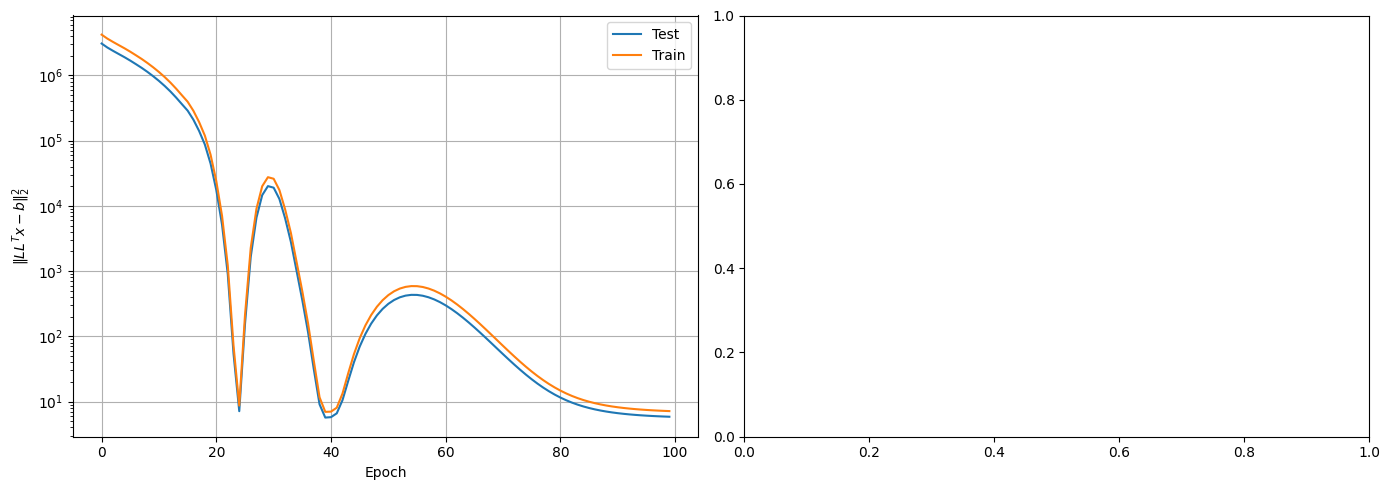

In [11]:
_, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(len(losses[0])), losses[1], label='Test')
axes[0].plot(range(len(losses[0])), losses[0], label='Train')
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('$\|LL^Tx - b\|_2^2$');
axes[0].grid();

# axes[1].plot(range(len(losses[0])), losses[2], label='Test')
# axes[1].legend()
# axes[1].set_yscale('log')
# axes[1].set_xlabel('Epoch')
# axes[1].set_ylabel('Condition number of $LL^T$')
# axes[1].grid();

# for vl in [129]:#[13, 17, 22, 25, 29, 39, 59, 79]:
#     axes[0].axvline(vl, 0, 1e11, linestyle='--', c='k')
#     axes[1].axvline(vl, 0, 1e11, linestyle='--', c='k')

plt.tight_layout()

# cond_A, cond_LLT = asses_cond(A_test, vmap(model, in_axes=(0, 0, 0, 0, 0), out_axes=(0))(*direc_graph_from_linear_system_sparse(A_test, b_test)[:-1], bi_edges_test))
print(f'Final values\n  train loss: {losses[0][-1]:.4f}\n   test loss: {losses[1][-1]:.4f}')#\n    LLT cond: {losses[2][-1]:.0f}')
print(f'\nMinimim test loss `{jnp.min(losses[1]).item():.4f}` at epoch `{jnp.argmin(losses[1]).item():.0f}`')
# print(f'\nMinimim test cond `{jnp.min(losses[2]).item():.0f}` at epoch `{jnp.argmin(losses[2]).item():.0f}`')
# print(f'\nTest lhs A cond: {cond_A:.0f}, test LLT cond: {cond_LLT:.0f}')

# Apply model to CG

In [12]:
# Not preconditioned
X_I, R_I = ConjGrad(A_test, b_test, N_iter=300, prec_func=None, seed=42)

In [13]:
# Prec = LL^T
L = vmap(model, in_axes=(0, 0, 0, 0, 0), out_axes=(0))(*direc_graph_from_linear_system_sparse(A_test, b_test)[:-1], bi_edges_test)
prec = partial(apply_LLT, L=L)

X_LLT, R_LLT = ConjGrad(A_test, b_test, N_iter=300, prec_func=prec, seed=42)

        Simple CG: {0.001: 48, 1e-06: 81, 1e-12: 143}
Preconditioned CG: {0.001: 10, 1e-06: 20, 1e-12: 38}


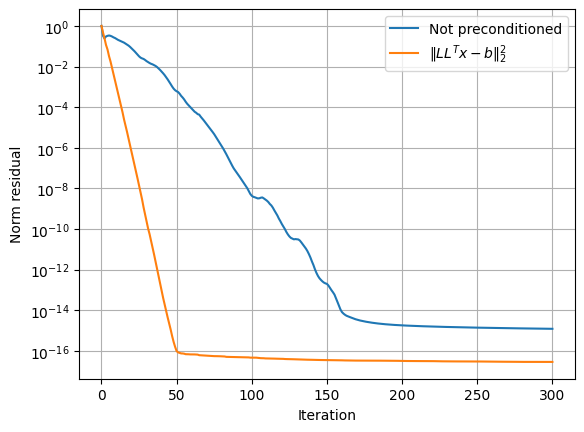

In [14]:
plt.plot(range(R_I.shape[-1]), jnp.linalg.norm(R_I, axis=1).mean(0), label="Not preconditioned")
plt.plot(range(R_LLT.shape[-1]), jnp.linalg.norm(R_LLT, axis=1).mean(0), label="$\|LL^Tx - b\|_2^2$")

plt.xlabel('Iteration')
plt.ylabel('Norm residual')
plt.legend();
plt.yscale('log')
plt.grid();

# plt.ylim([1e-15, 1e0]);
# plt.vlines(110, 1e-15, 1, linestyle='--', color='k')

res_I_dict = iter_per_residual(R_I)
res_LLT_dict = iter_per_residual(R_LLT)
print('        Simple CG:', res_I_dict)
print('Preconditioned CG:', res_LLT_dict)

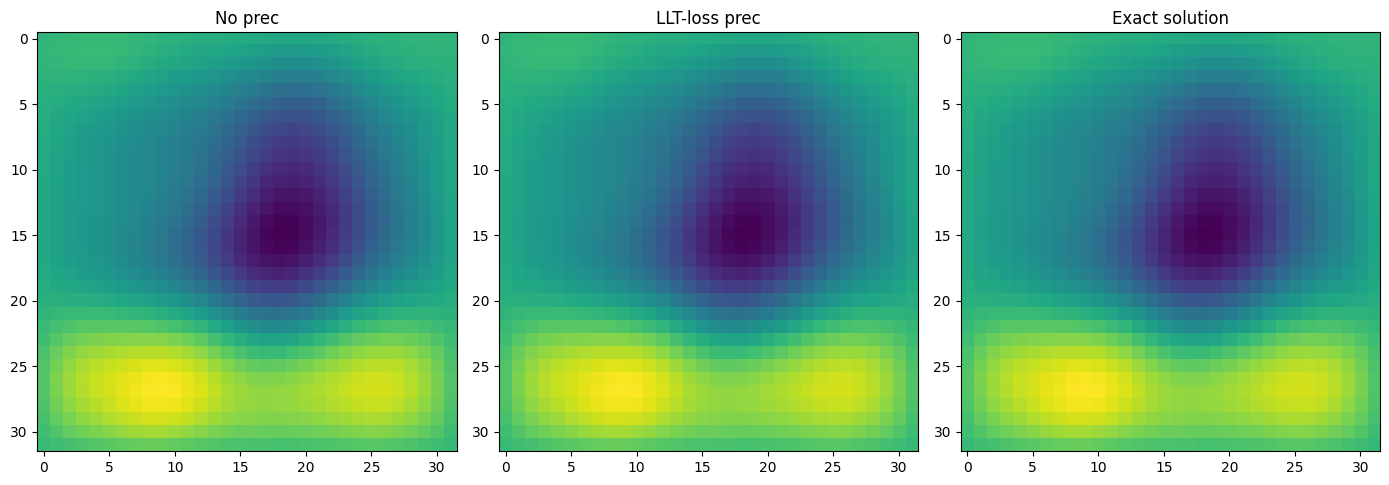

In [15]:
_, axes = plt.subplots(1, 3, figsize=(14, 14))

axes[0].imshow(X_I[0, :].reshape([grid]*2))
axes[1].imshow(X_LLT[0, :].reshape([grid]*2))
axes[2].imshow(u_exact_test[0, :].reshape([grid]*2))

axes[0].set_title('No prec')
axes[1].set_title('LLT-loss prec')
axes[2].set_title('Exact solution')
    
plt.tight_layout()

In [16]:
jnp.abs(b_test[0, ...] - A_test[0, ...].todense() @ u_exact_test[0, ...]).max()

Array(2.013985e-07, dtype=float32)

In [17]:
from jax import scipy as  jscipy

In [18]:
L_ = L[0, ...].todense()

y, _ = jscipy.sparse.linalg.bicgstab(L_, b_test[0, ...])
u_exact_LLT, _ = jscipy.sparse.linalg.bicgstab(L_.T, y)

jnp.abs(b_test[0, ...] - A_test[0, ...].todense() @ u_exact_LLT).max()

Array(0.01684442, dtype=float32)

In [21]:
jnp.savez('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/L_grid32.npz', L=L_)